In [1]:
from pathlib import Path
training_dir = Path(r"E:\Trackmania Data\processed_data_1500\train")
validation_dir = Path(r"E:\Trackmania Data\processed_data_1500\val")


In [2]:
import tensorflow as tf

from keras.models import Model
from keras import layers
from keras import backend as K


C:\Users\mivog\AppData\Local\Programs\Python\Python36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [5]:
# 
# from keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1/255)
# test_datagen = ImageDataGenerator(rescale=1/255)
# batch_size = 20
# 
# train_generator = train_datagen.flow_from_directory(
#     training_dir,
#     target_size=(32, 32),  # height, width
#     color_mode="grayscale",
#     batch_size=batch_size,
#     class_mode="categorical"
# )
# 
# validation_generator = test_datagen.flow_from_directory(
#     validation_dir,
#     target_size=(32, 32),
#     color_mode="grayscale",
#     batch_size=batch_size,
#     class_mode="categorical"
# )

from training import generators
train_generator, validation_generator = generators(training_dir, validation_dir, batch_size=32, height_width=(50, 50))
class_indices = train_generator.class_indices
index_class_dict = {v: k for k, v in train_generator.class_indices.items()}
print(index_class_dict)

Found 8997 images belonging to 5 classes.


Found 3000 images belonging to 5 classes.


{0: 'A', 1: 'AW', 2: 'D', 3: 'DW', 4: 'W'}


In [7]:
from keras_applications.mobilenet_v2 import relu6

from training import custom_accs
from keras.utils.generic_utils import get_custom_objects
from keras.models import load_model

get_custom_objects().update(
        {
         "A_class_accuracy": custom_accs(class_indices)["A_class_accuracy"],
         "AW_class_accuracy": custom_accs(class_indices)["AW_class_accuracy"],
         'relu6': relu6
         }
    )
model = load_model(
    r"E:\Trackmania Data\runs\run_mobilenetV2newprocessdata.batch_size32.epochs111-start_time20180727-031622\checkpoints\checkpoint.45-0.81.hdf5",
)
# model.summary()

{'A': '0.0', 'AW': '0.0', 'D': '0.0', 'DW': '0.0', 'W': '1.0'}


C:\Users\mivog\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


C:\Users\mivog\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


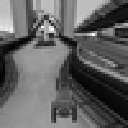

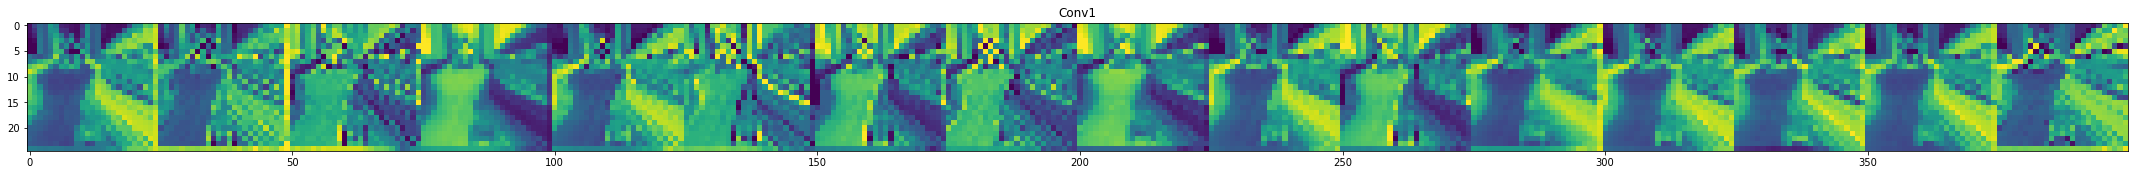

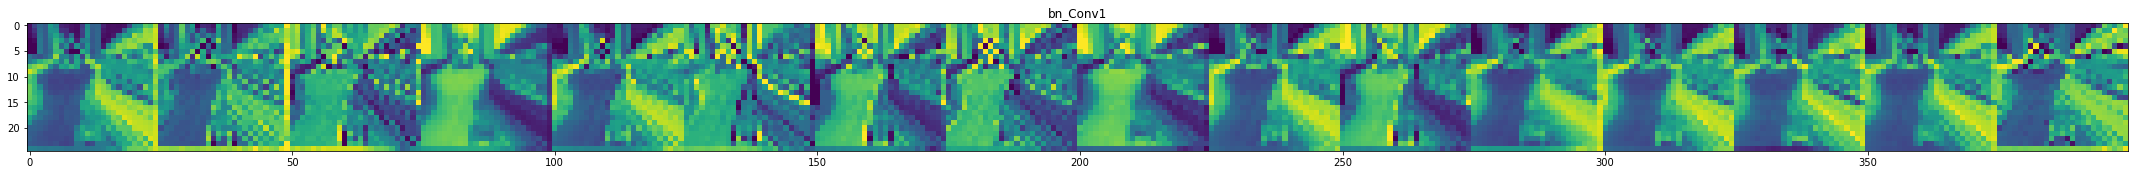

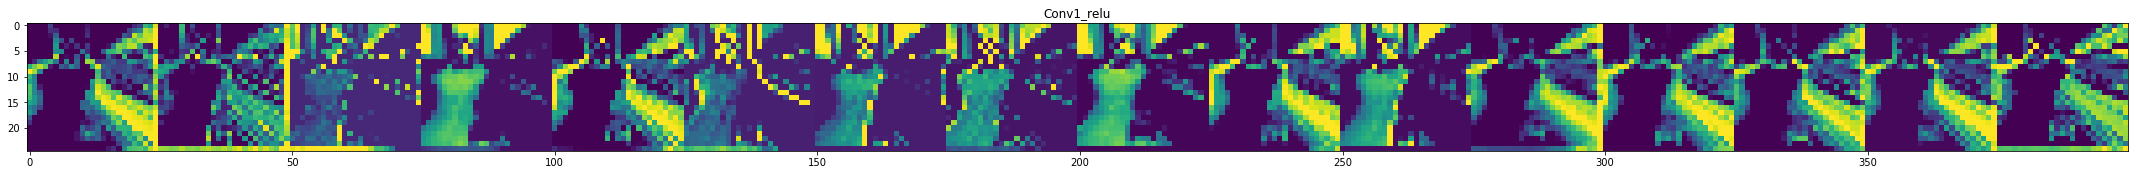

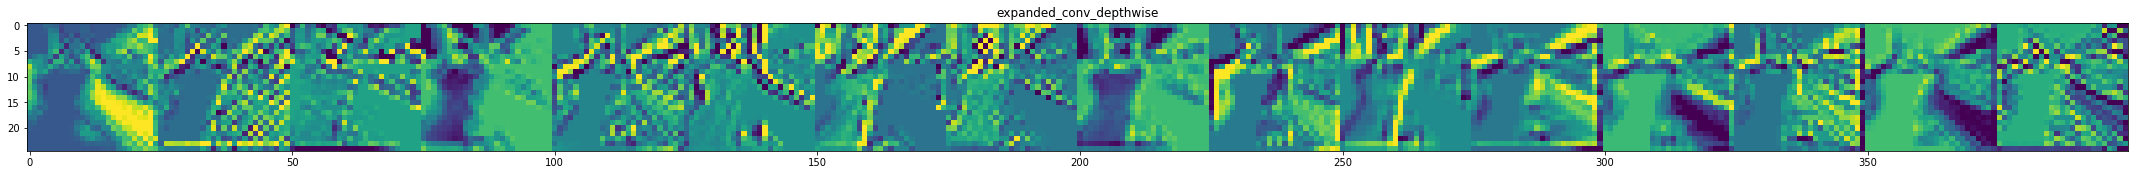

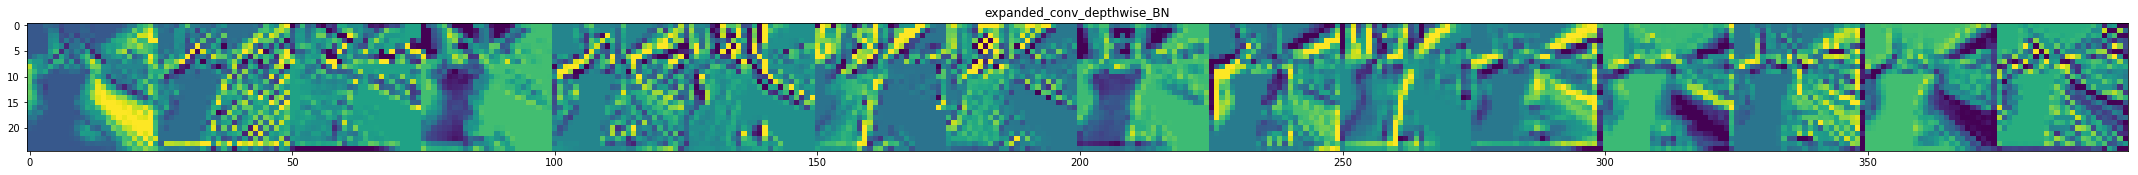

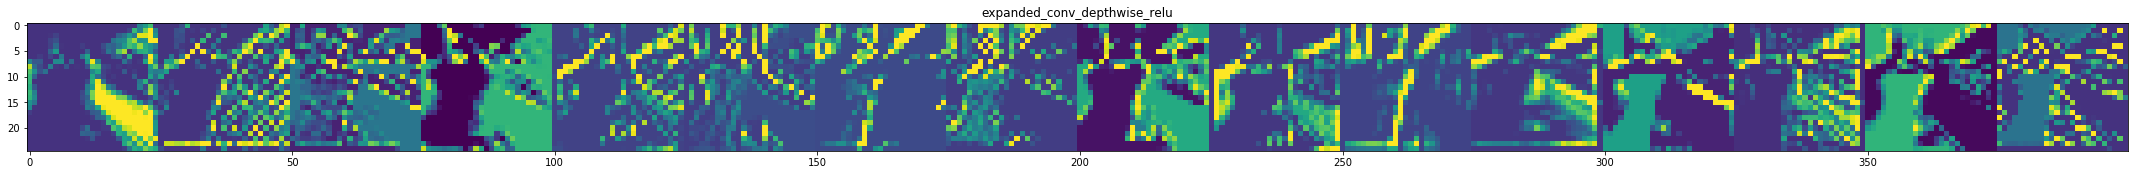

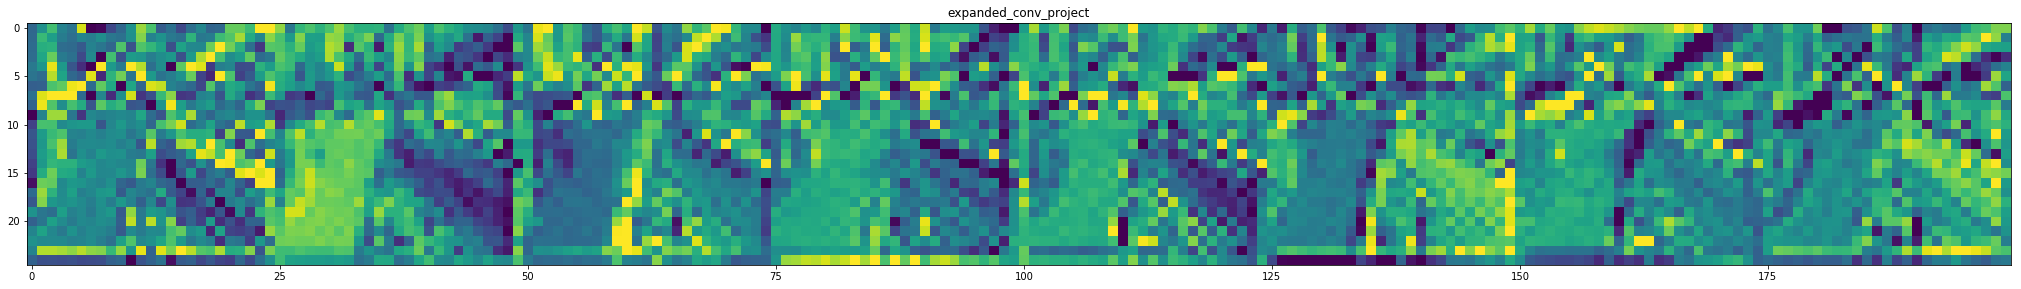

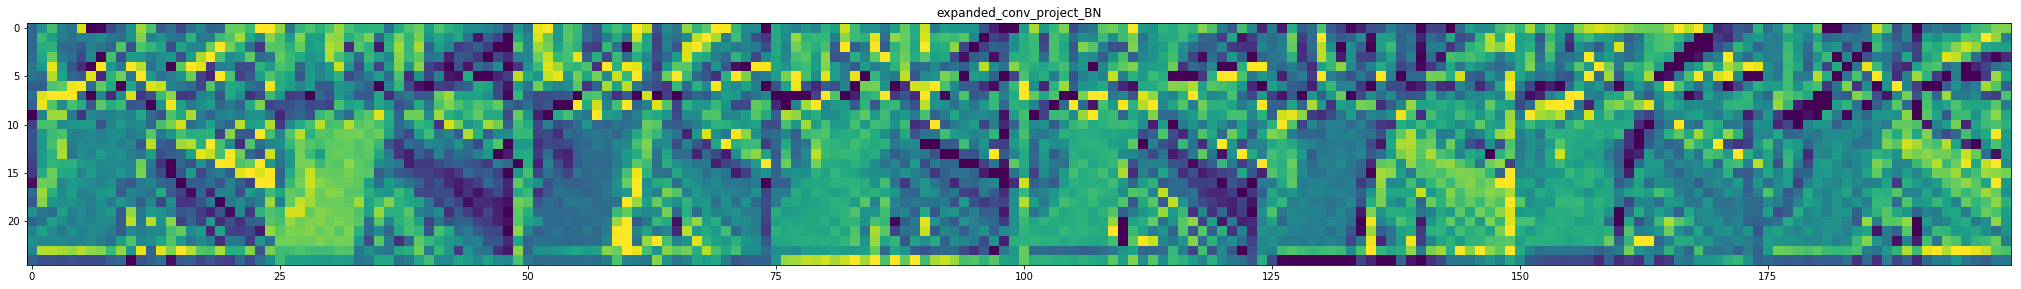

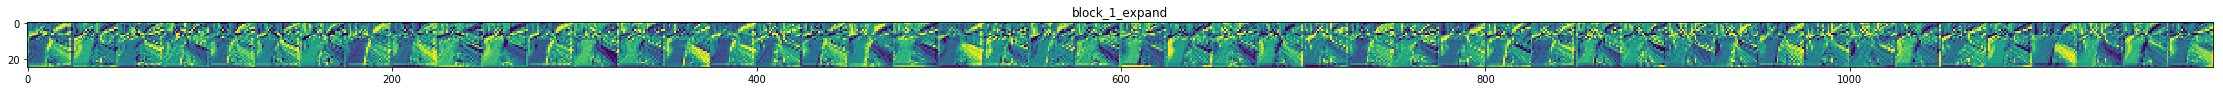

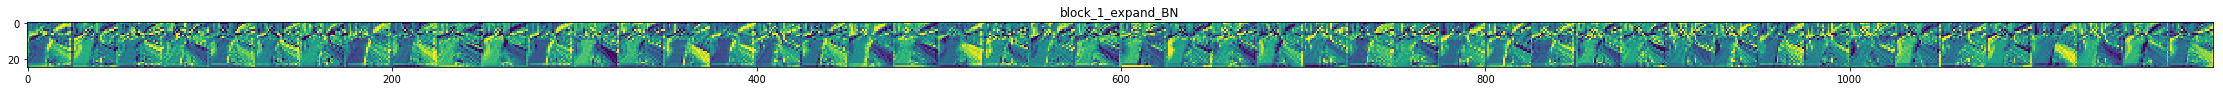

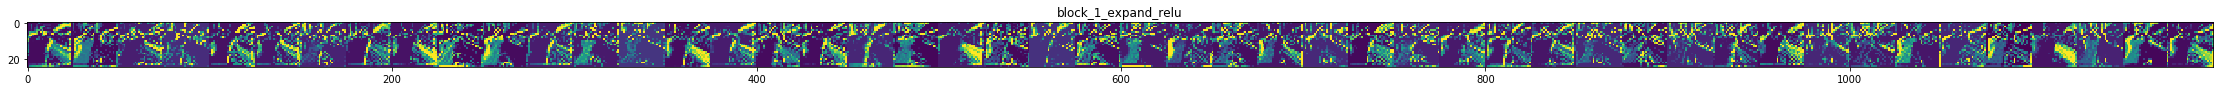

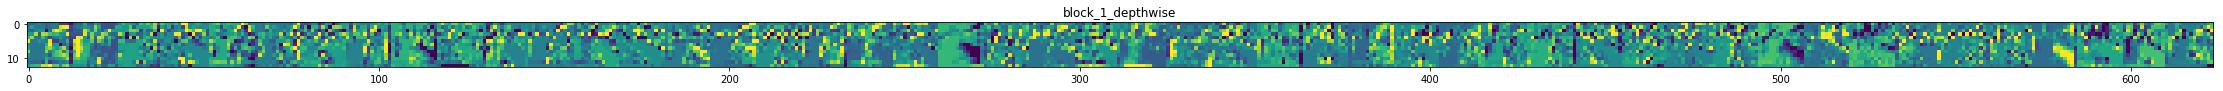

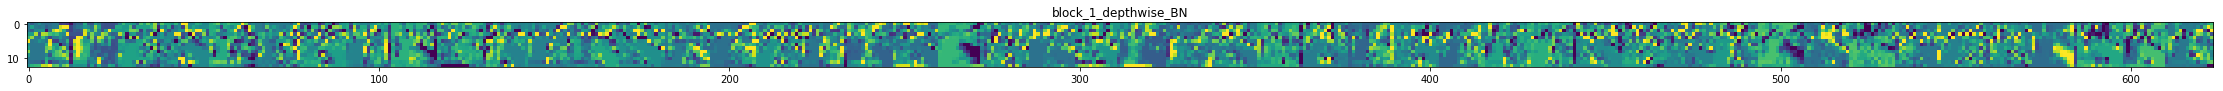

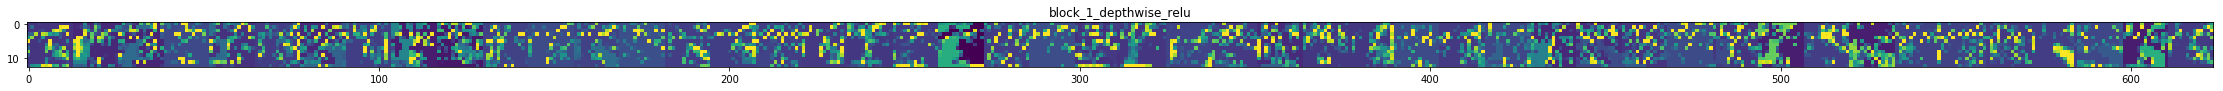

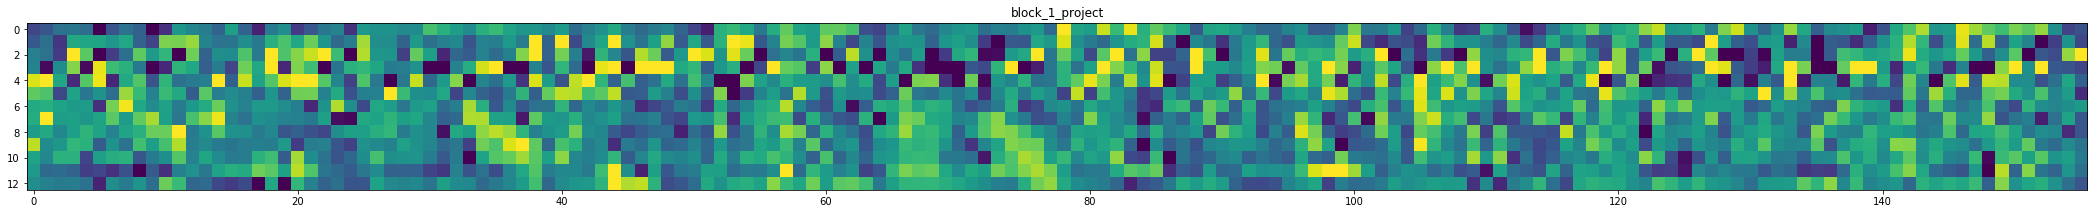

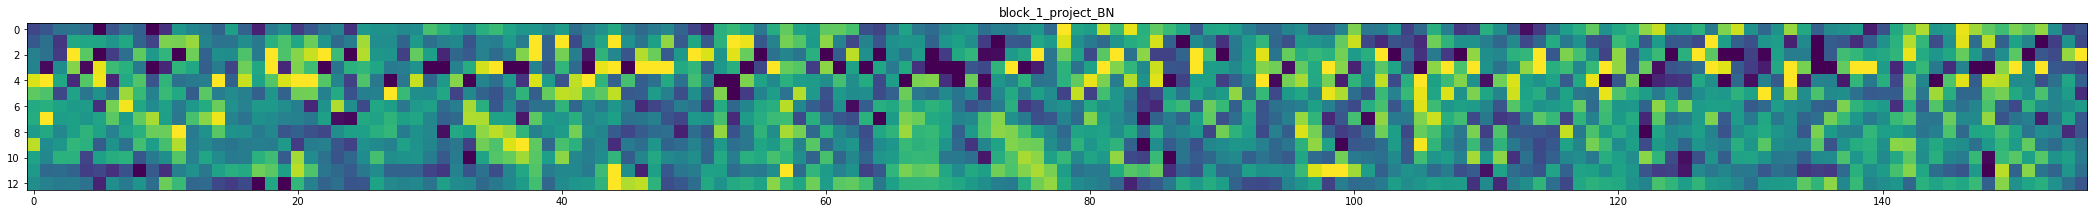

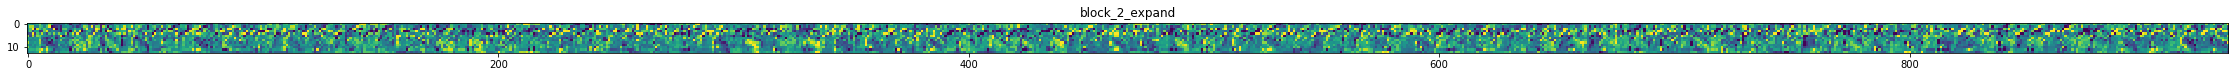

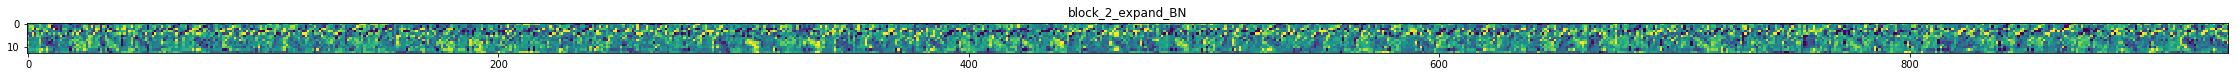

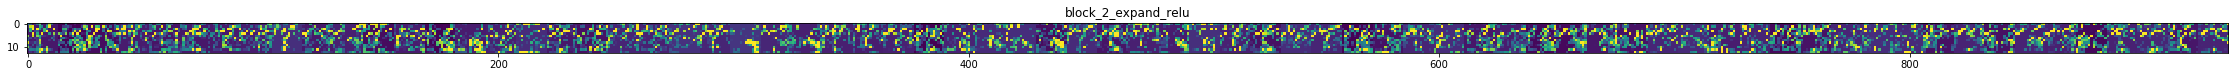

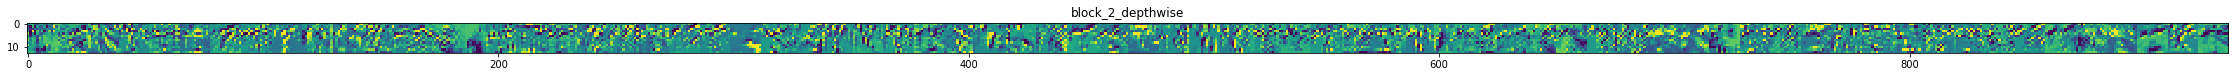

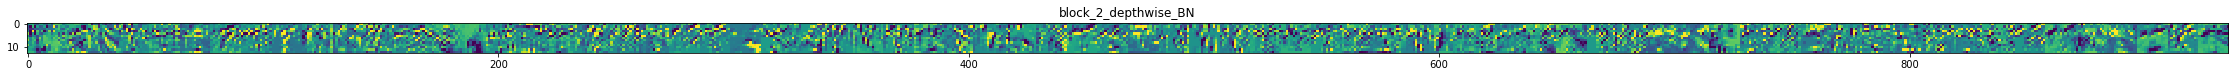

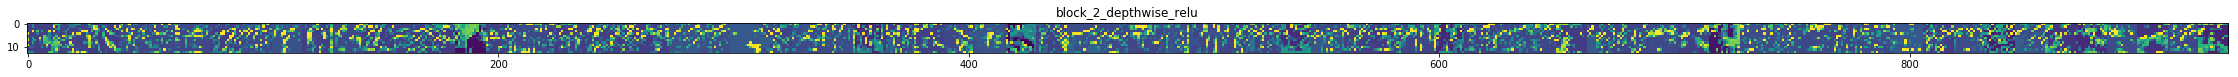

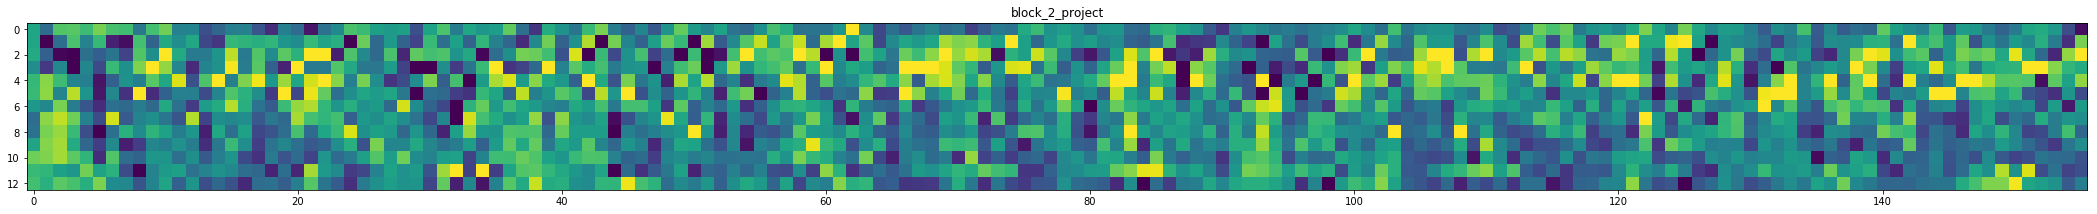

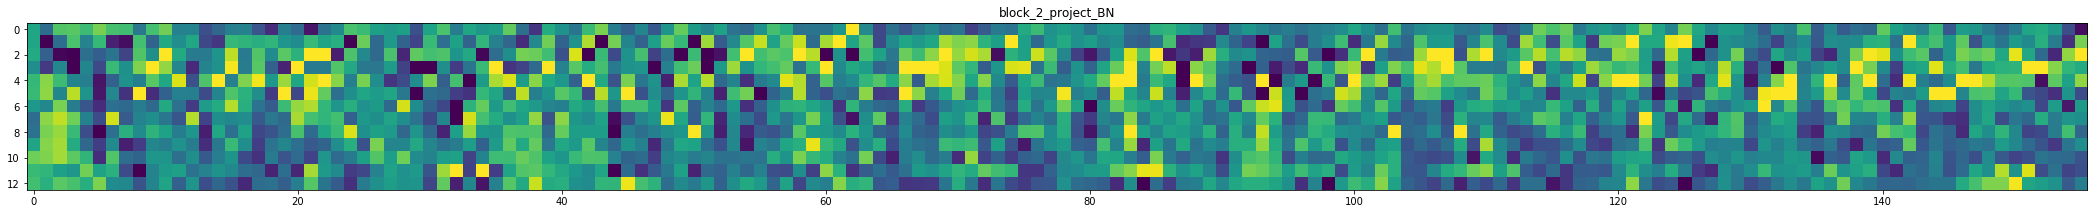

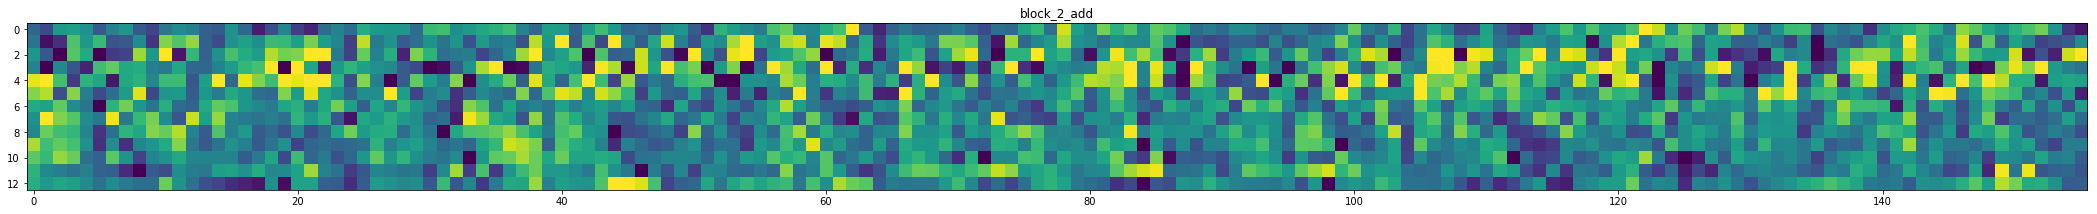

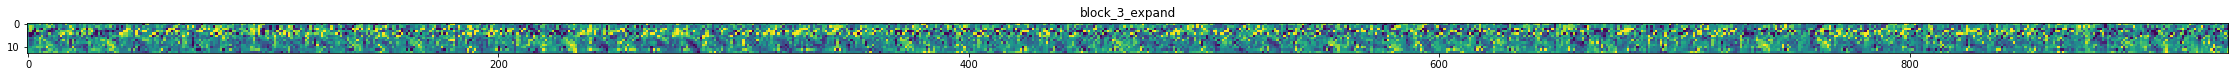

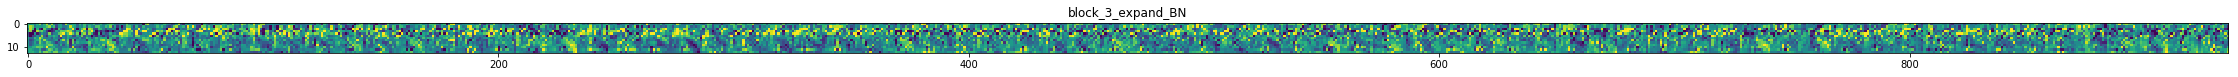

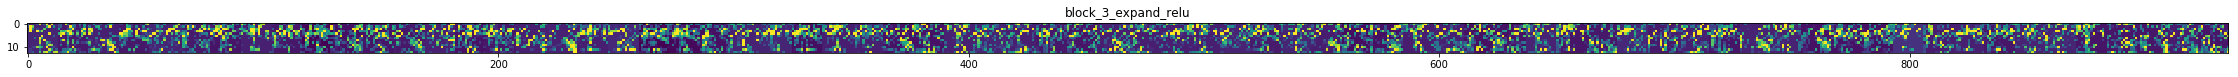

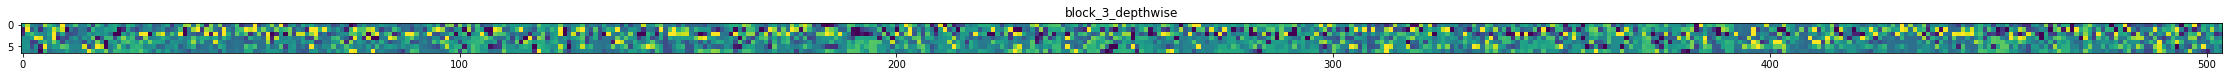

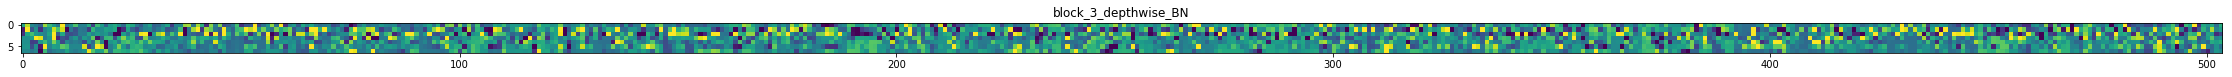

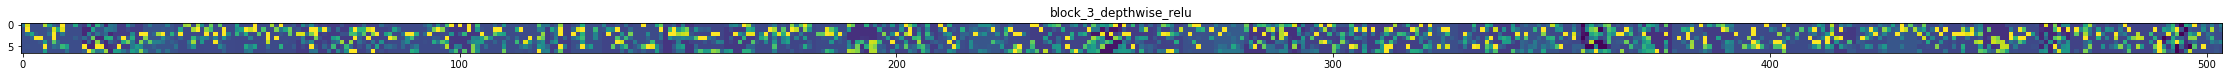

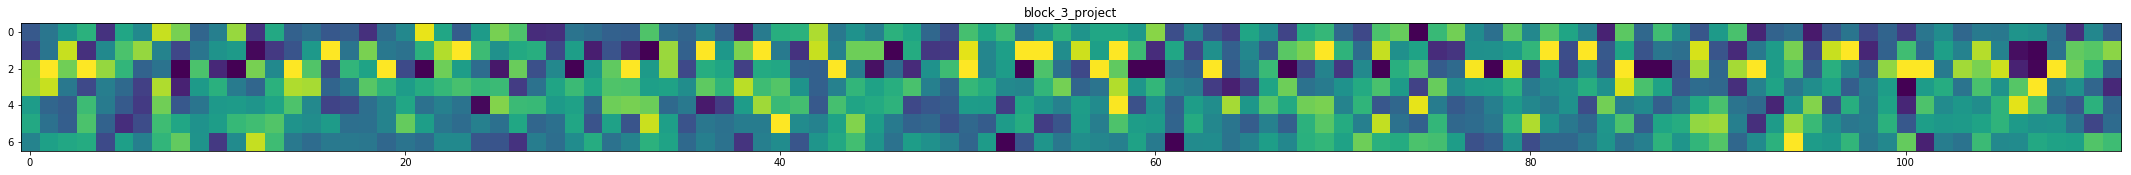

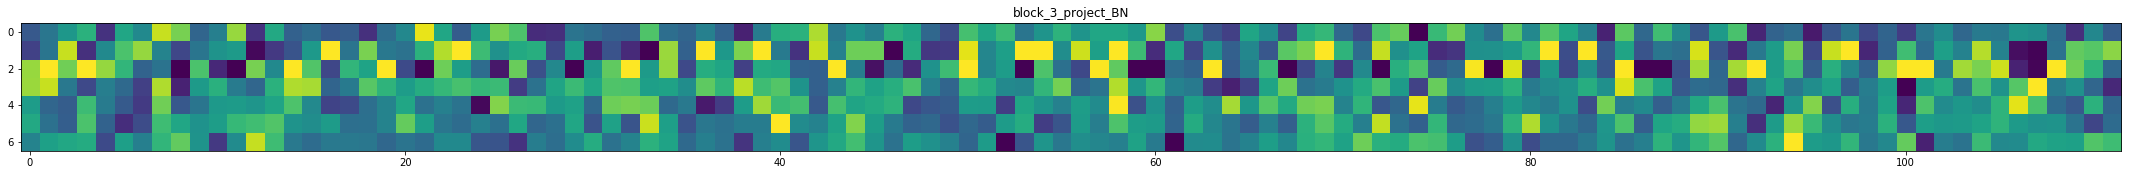

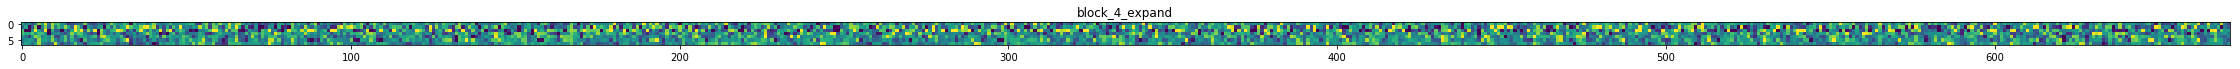

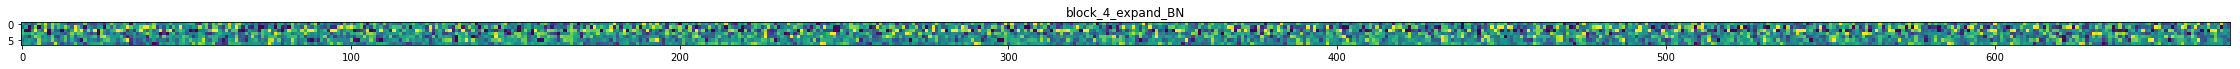

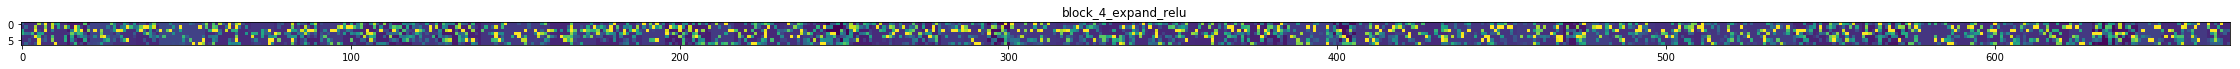

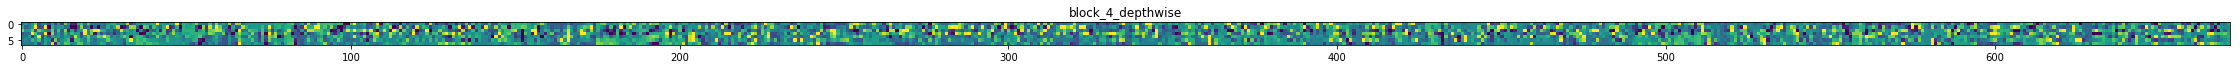

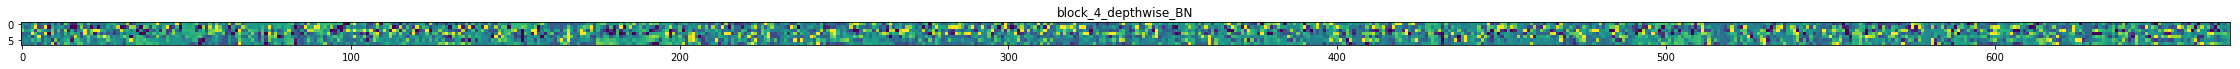

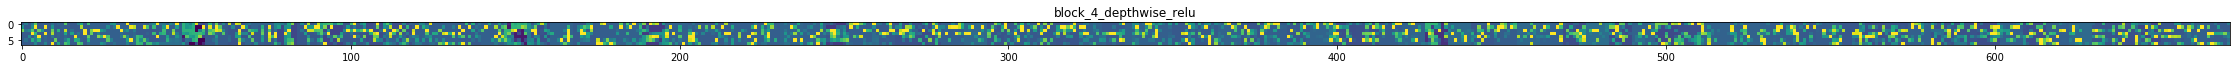

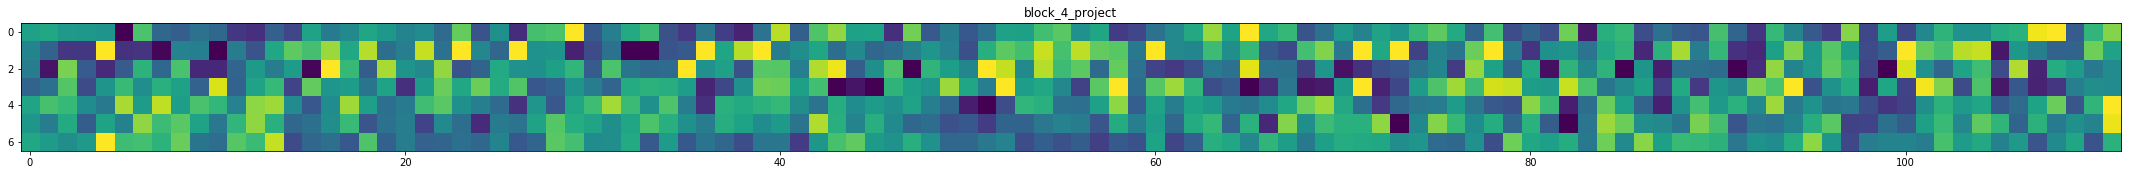

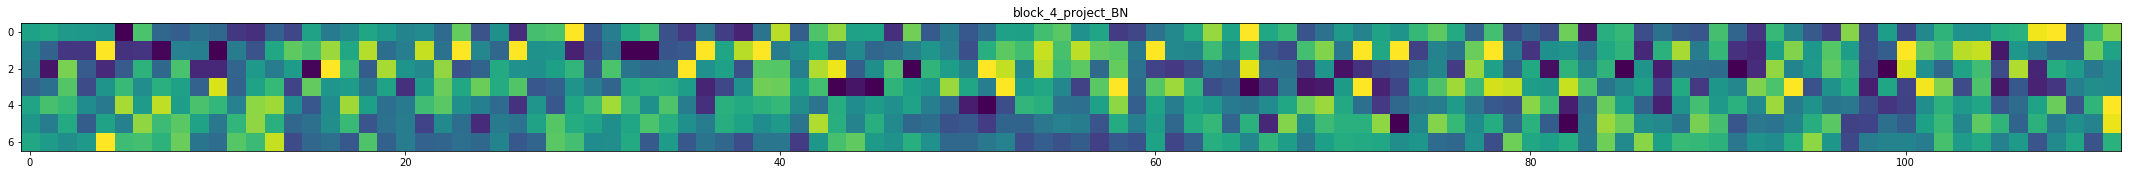

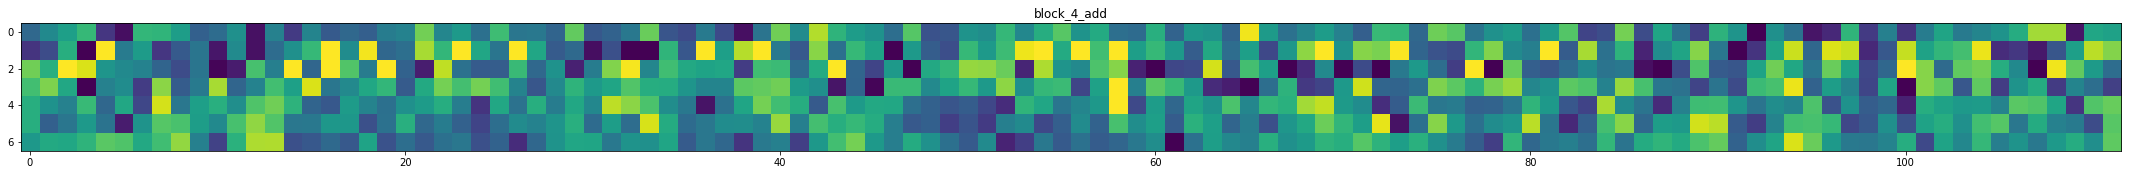

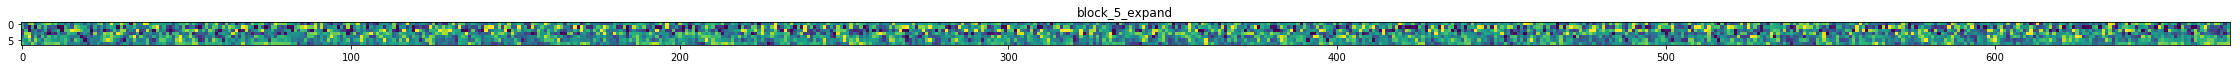

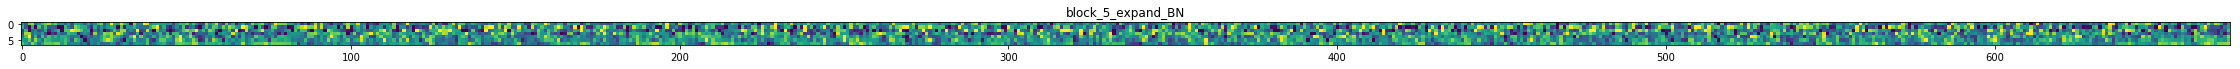

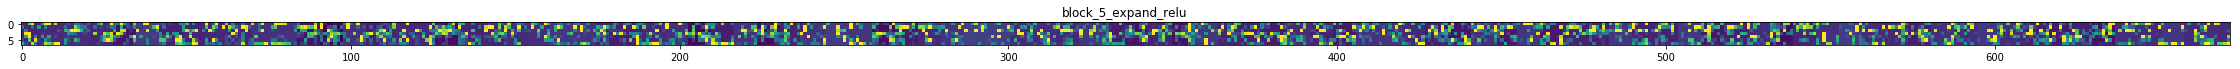

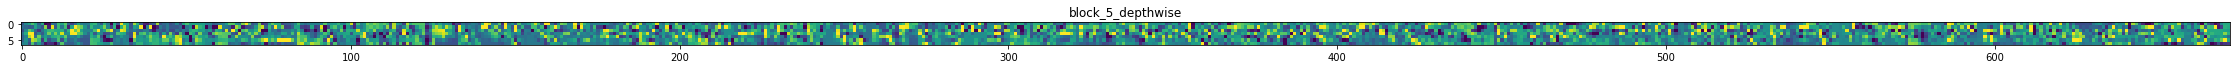

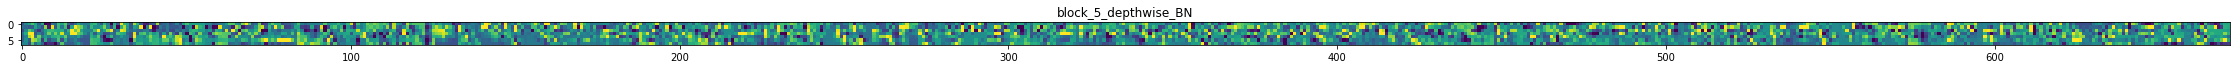

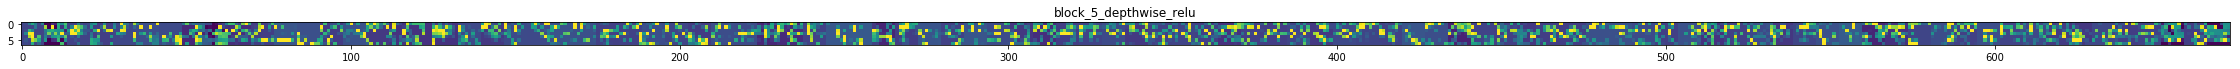

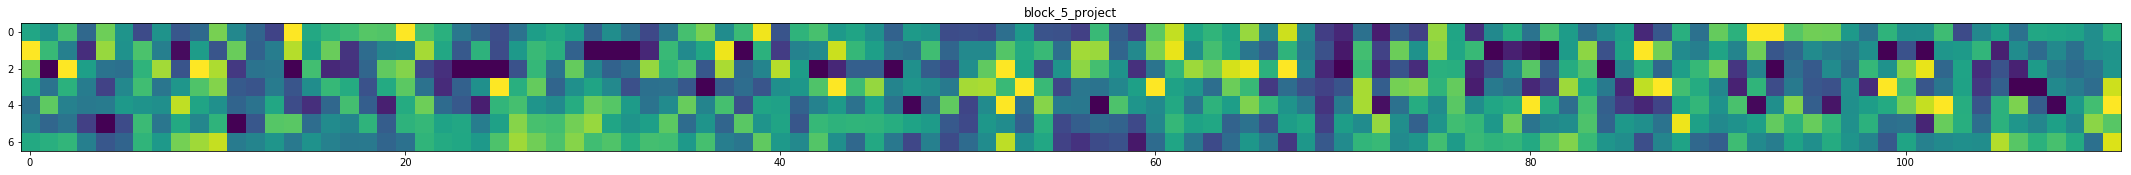

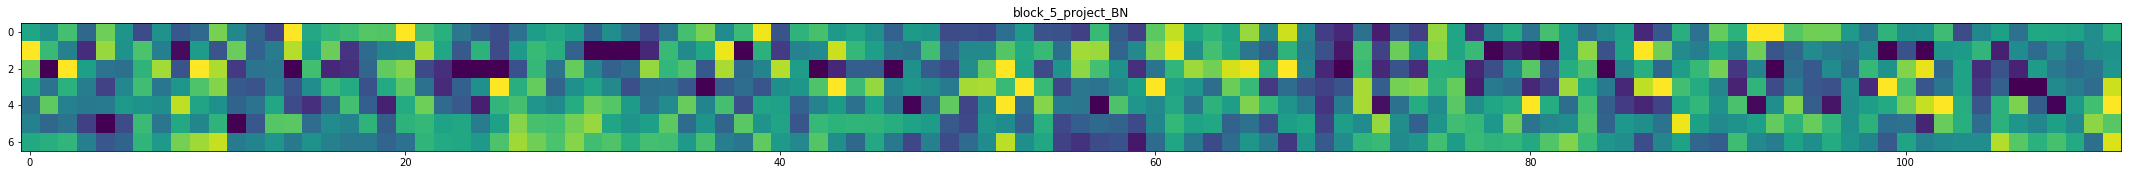

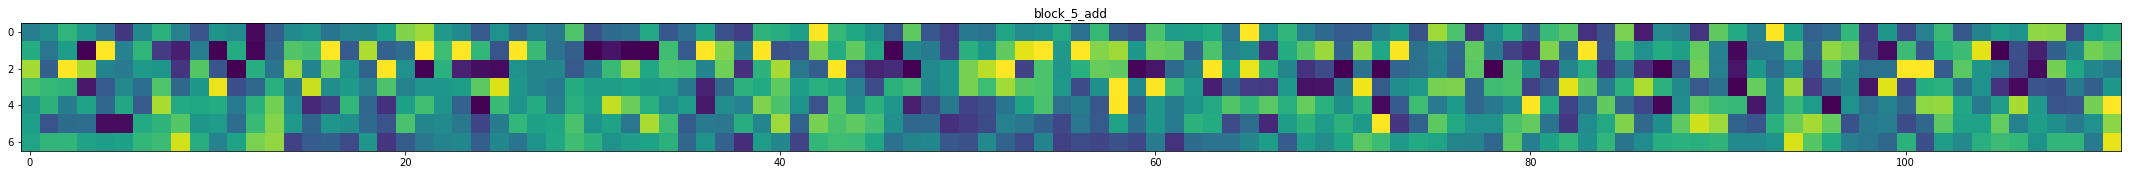

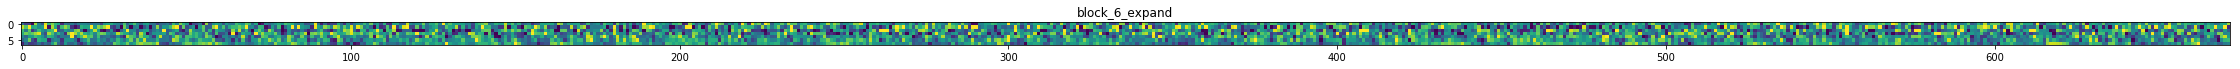

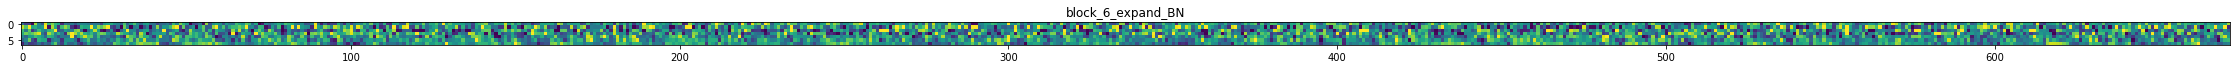

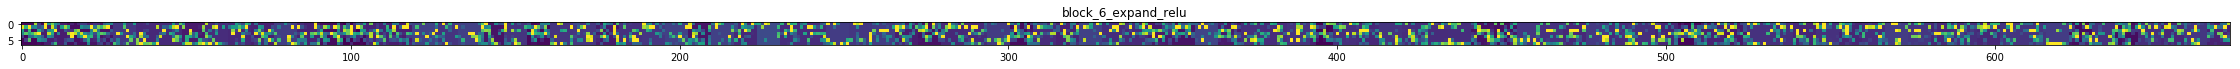

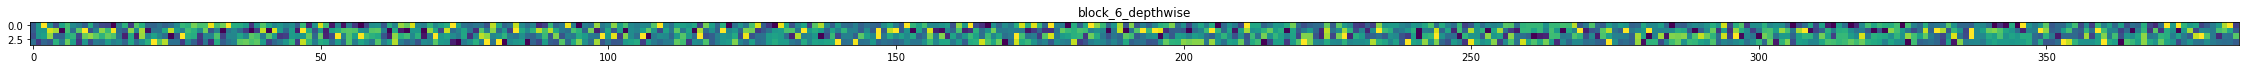

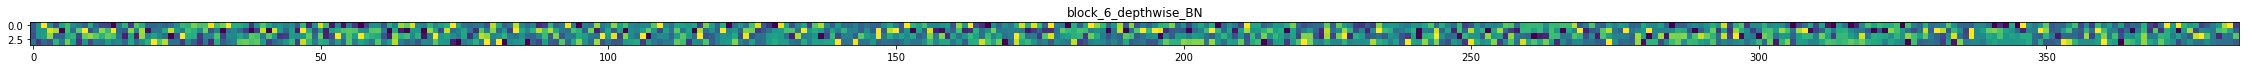

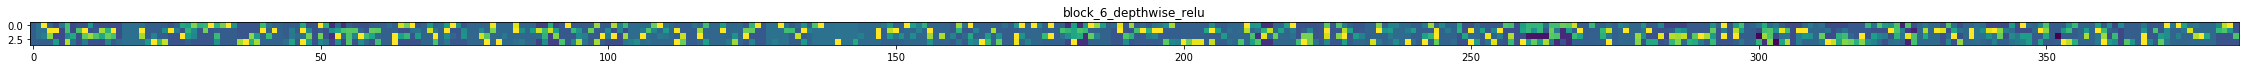

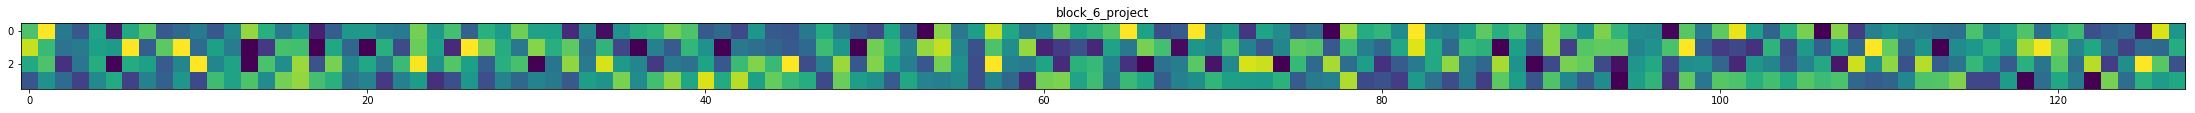

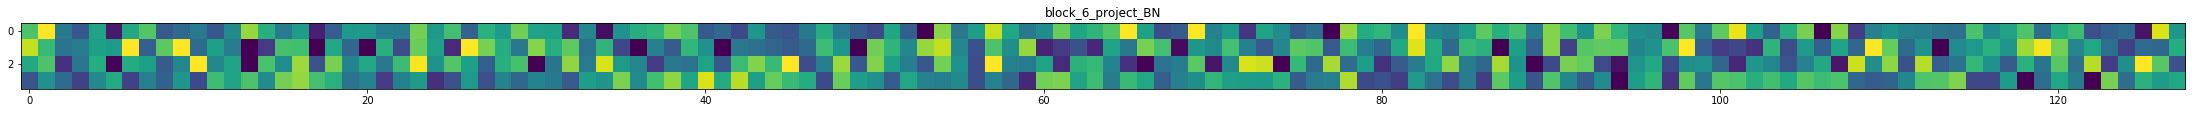

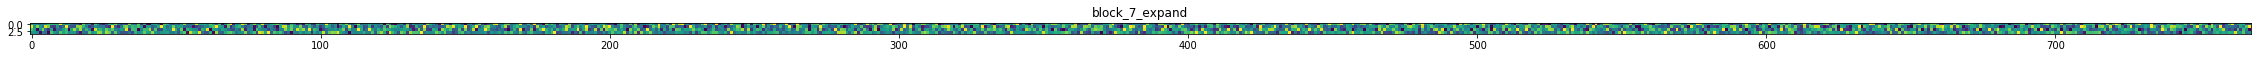

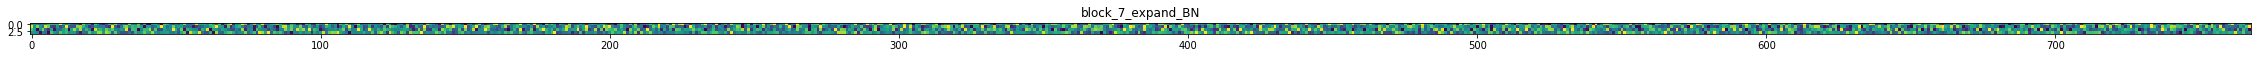

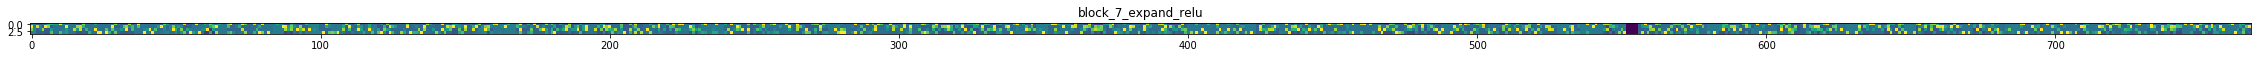

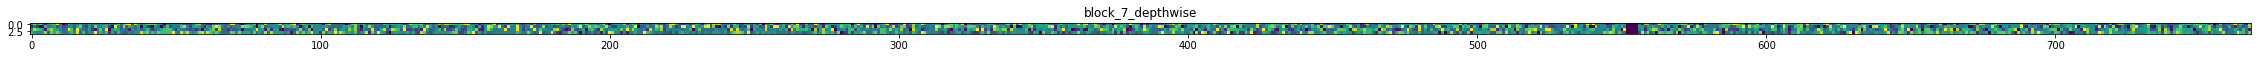

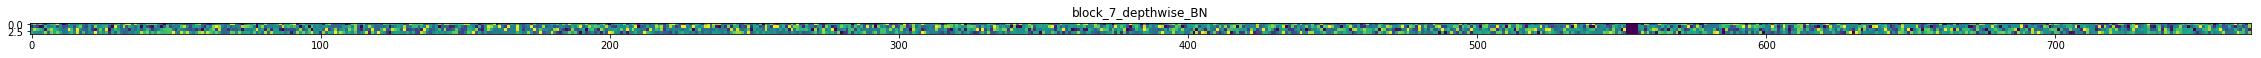

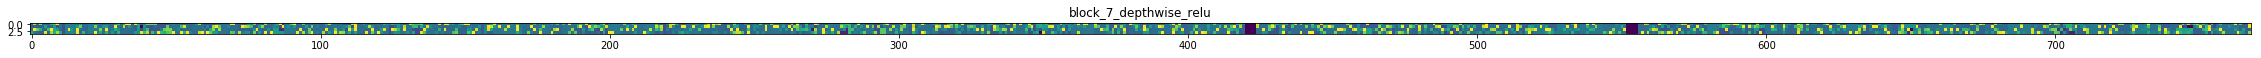

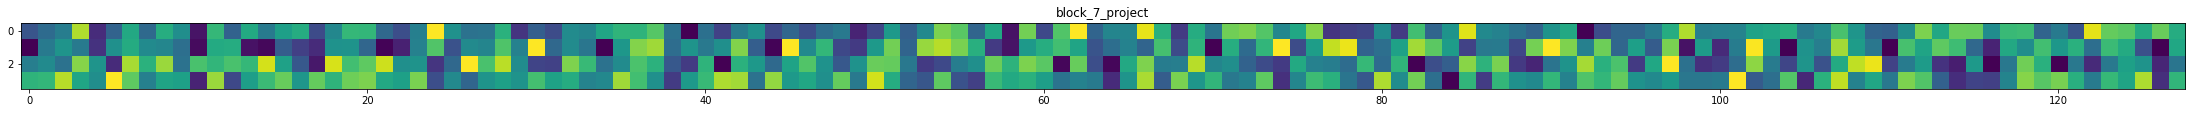

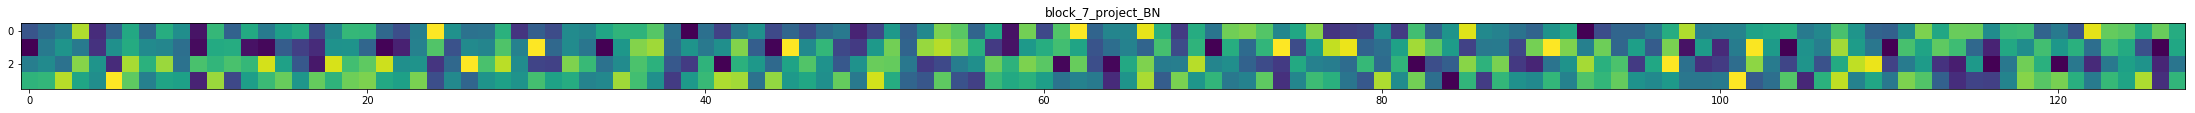

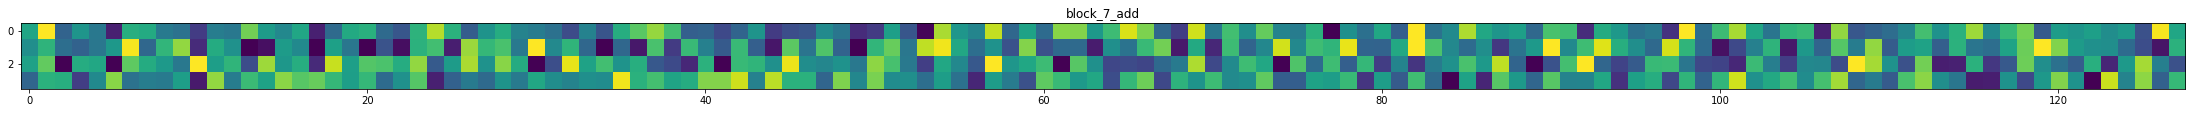

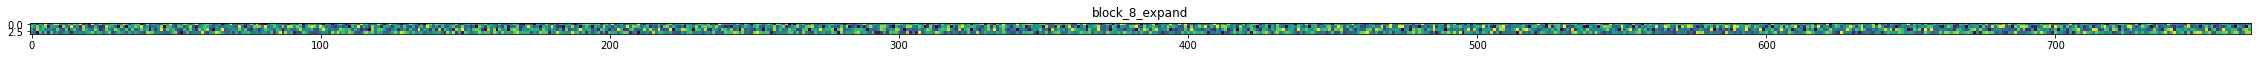

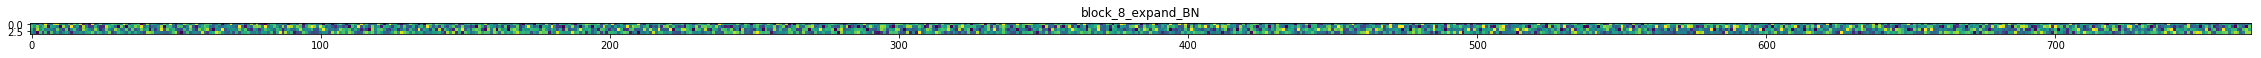

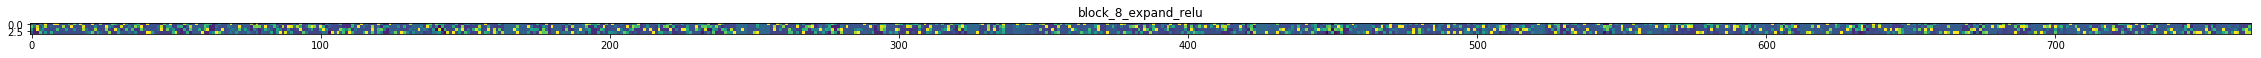

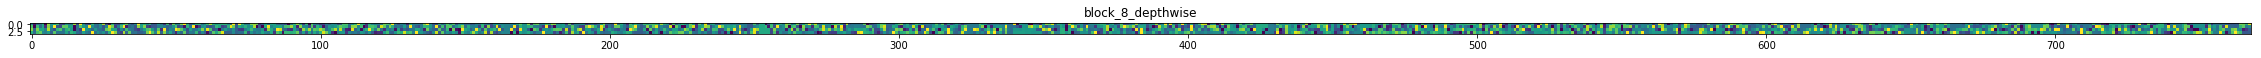

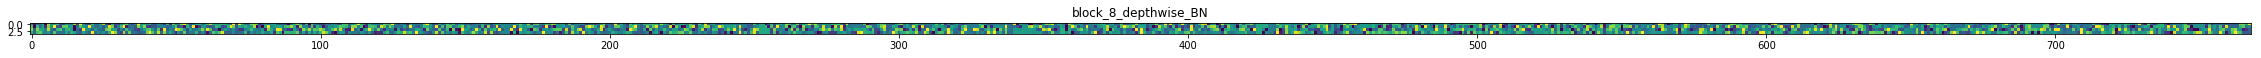

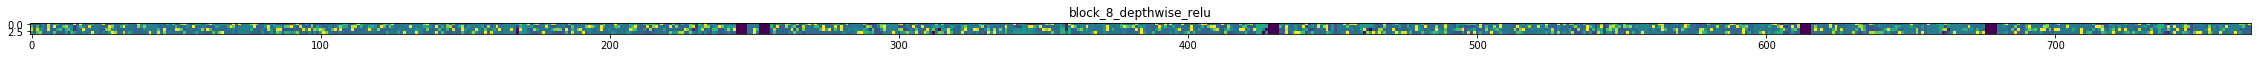

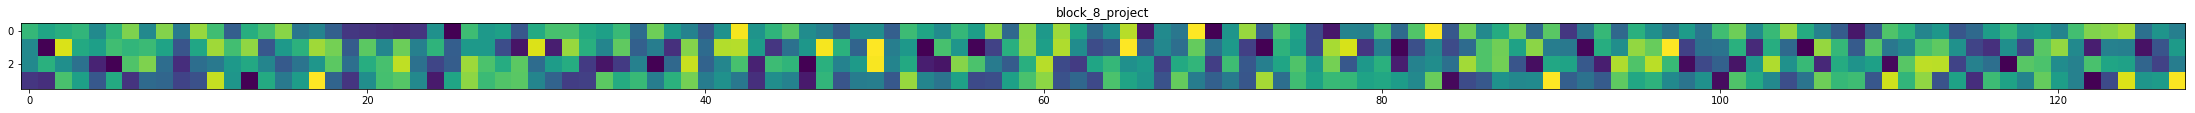

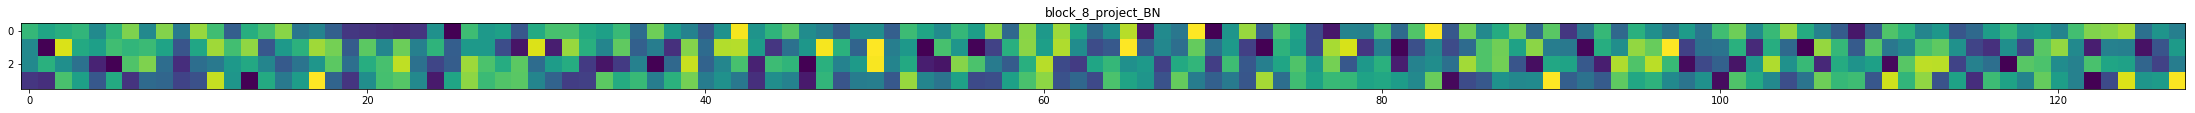

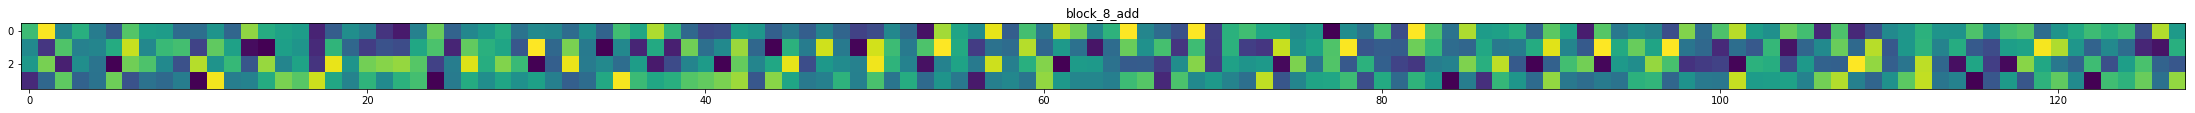

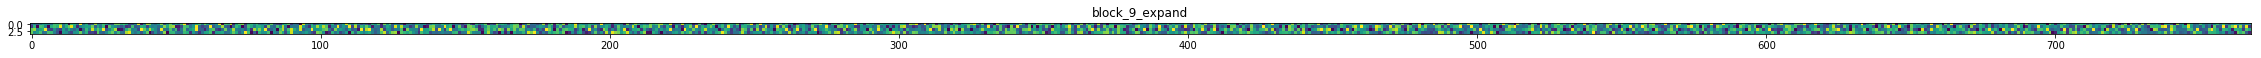

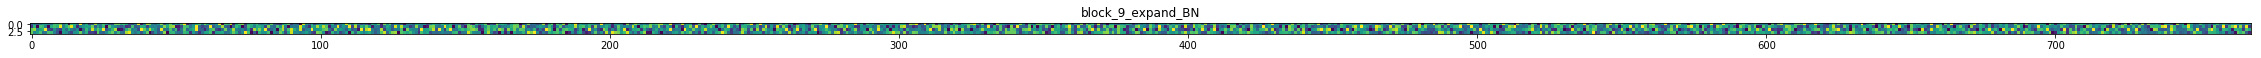

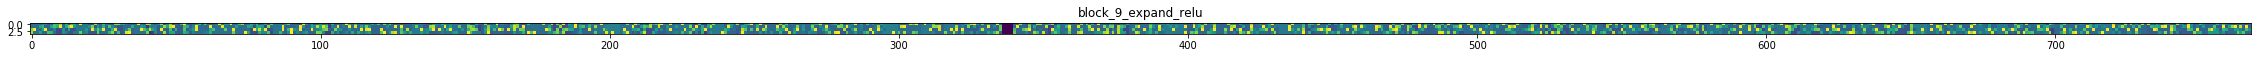

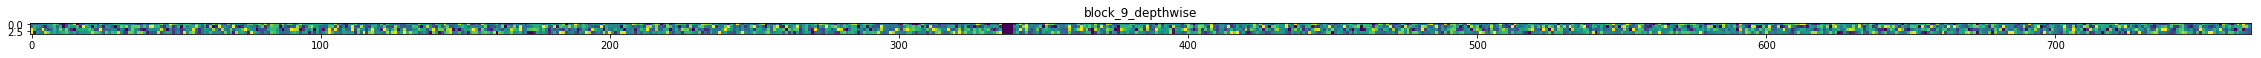

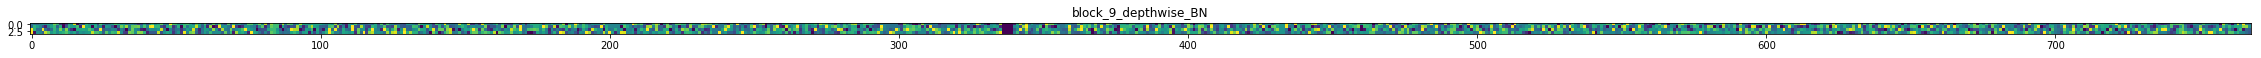

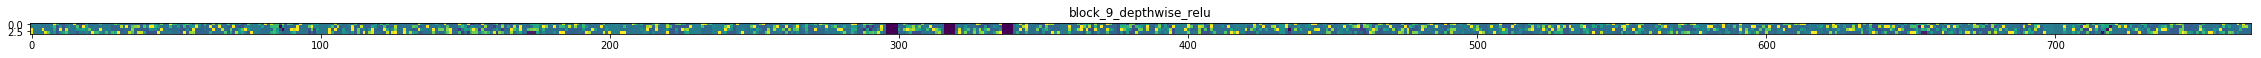

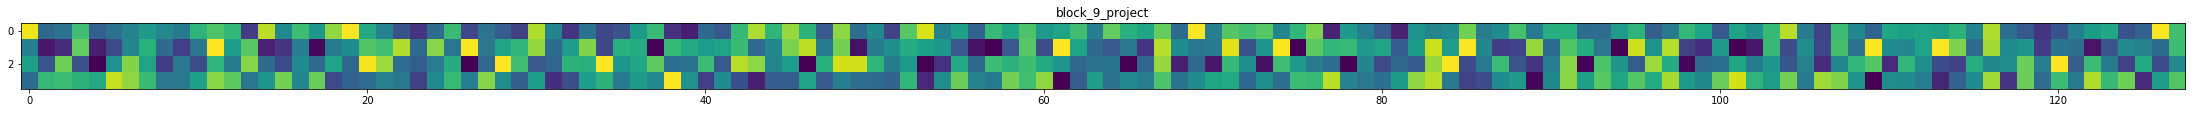

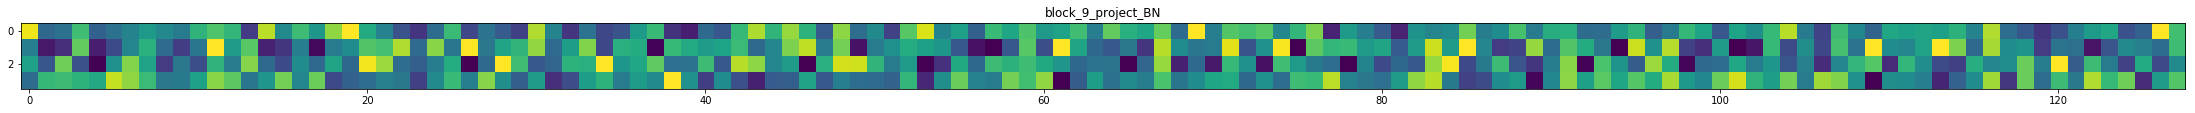

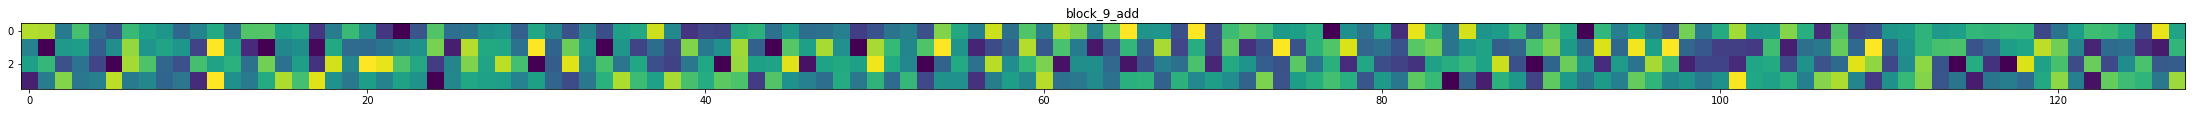

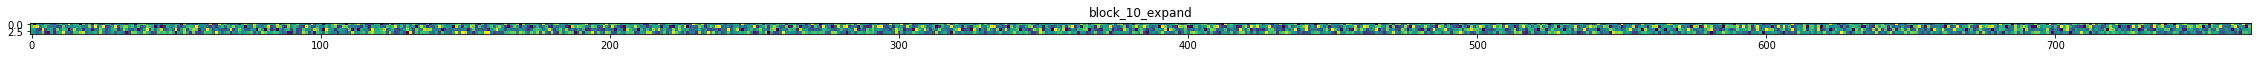

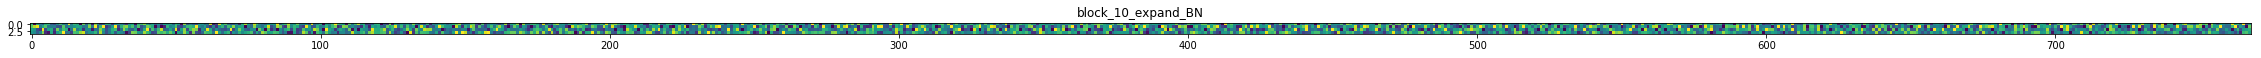

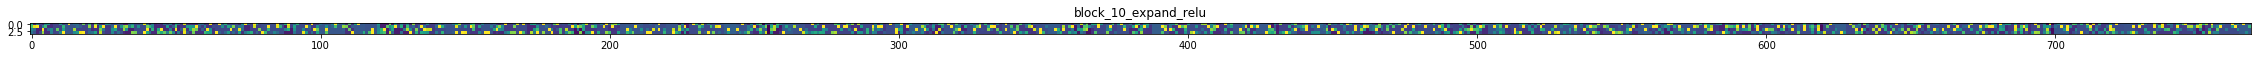

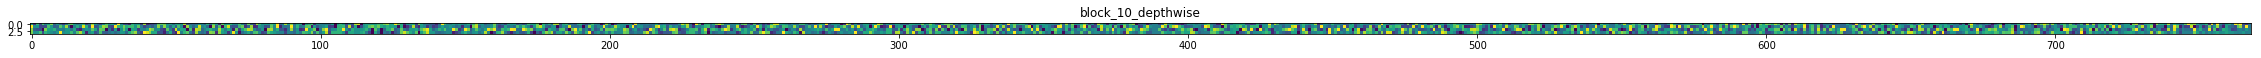

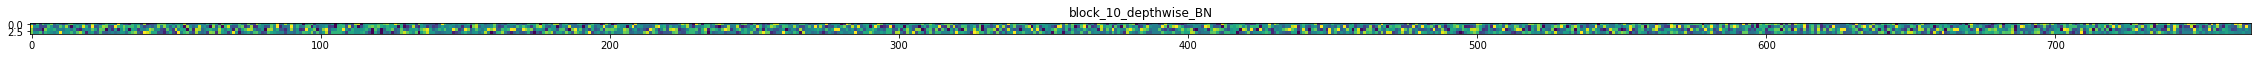

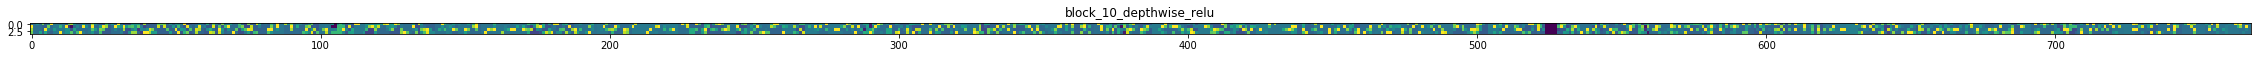

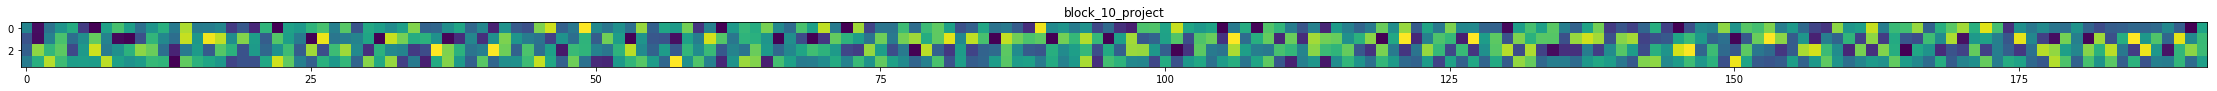

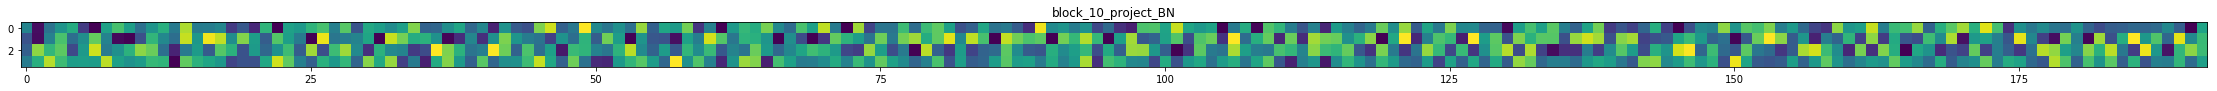

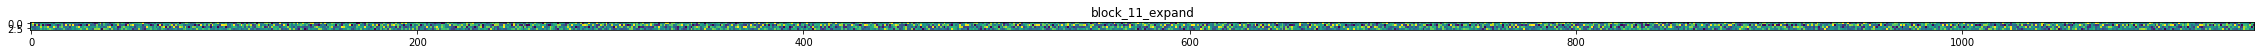

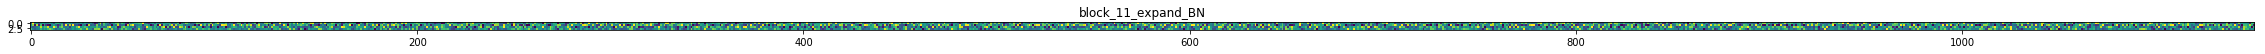

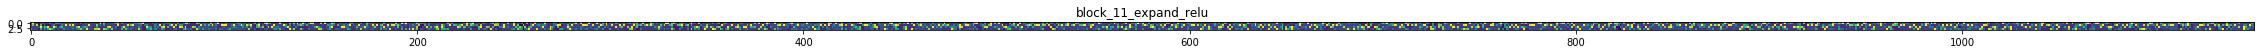

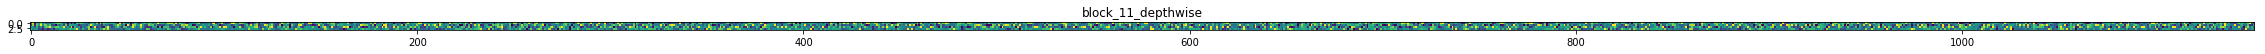

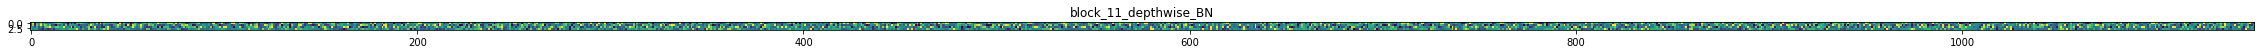

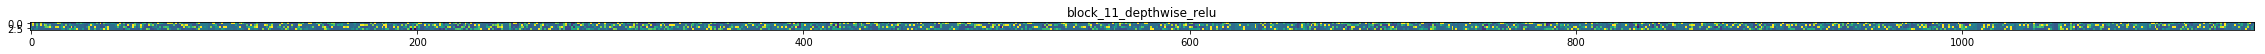

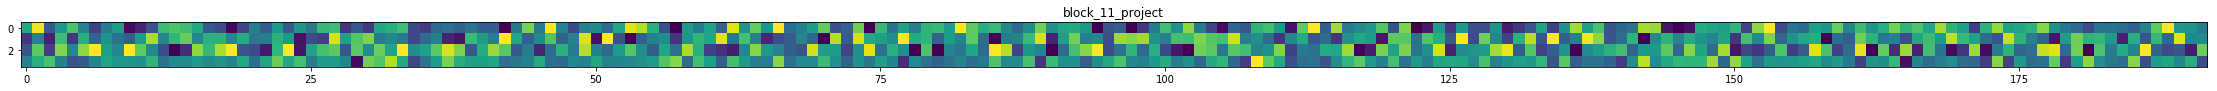

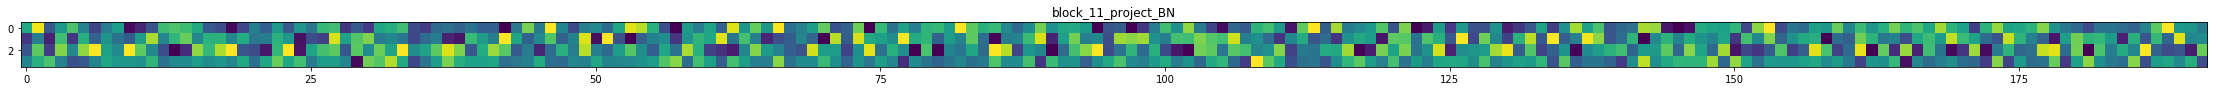

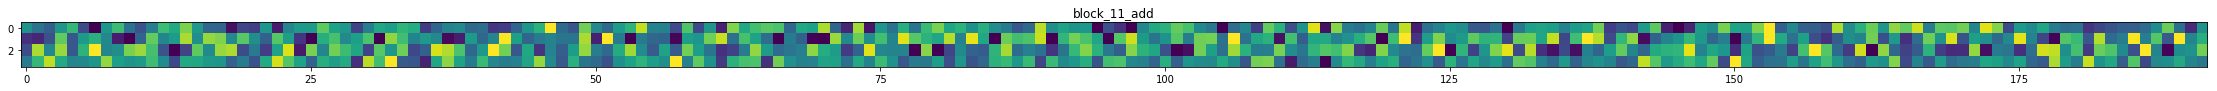

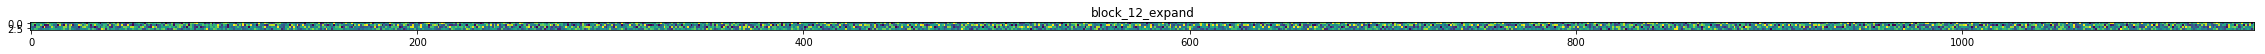

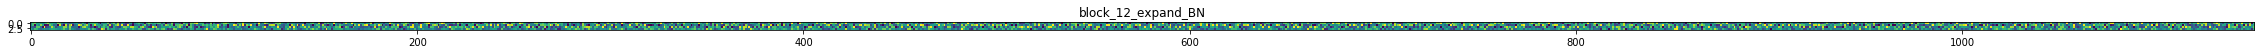

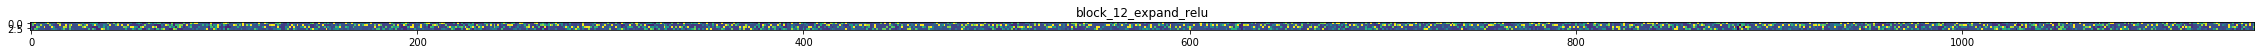

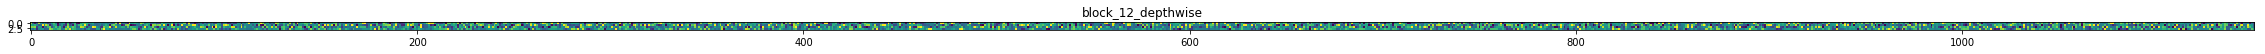

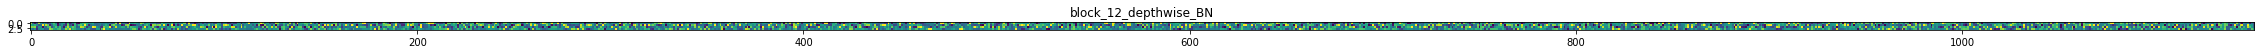

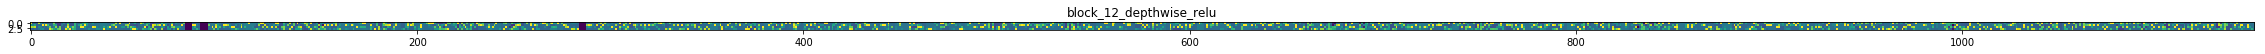

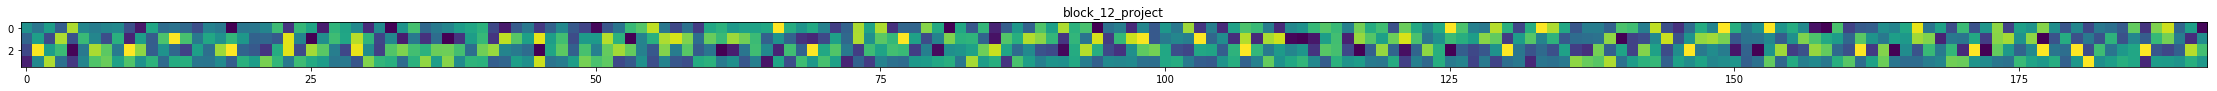

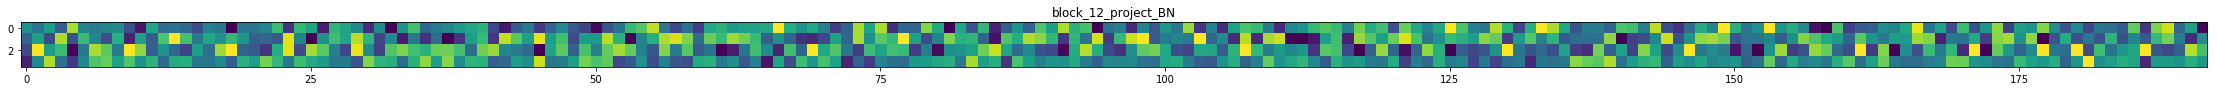

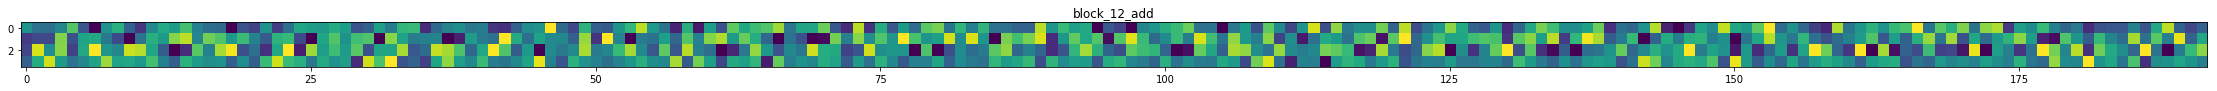

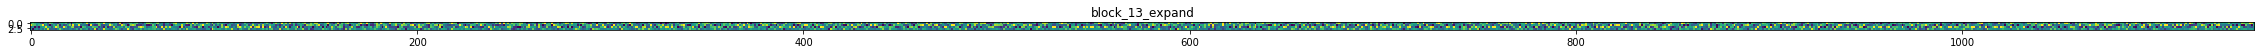

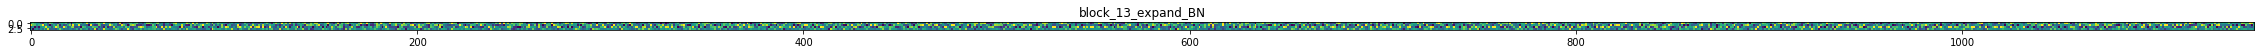

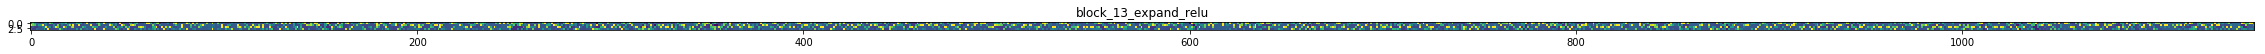

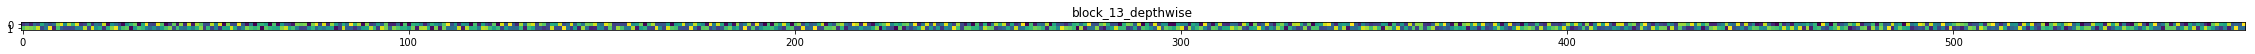

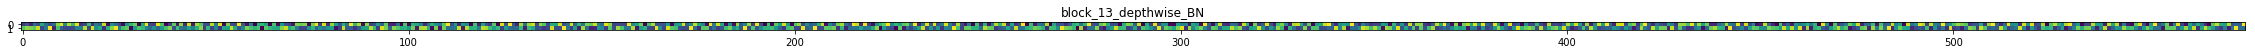

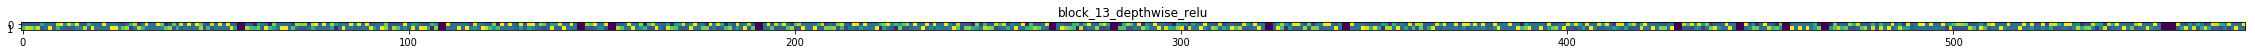

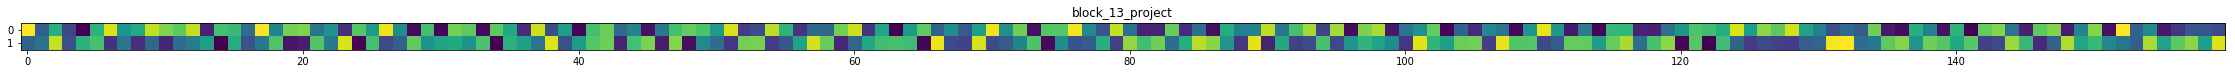

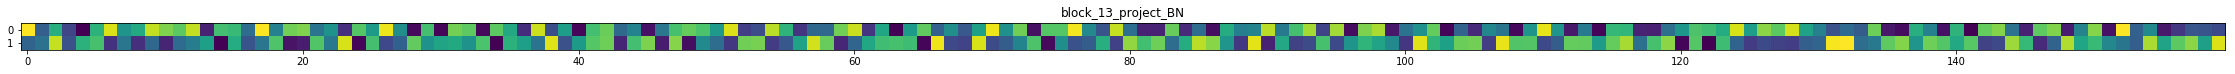

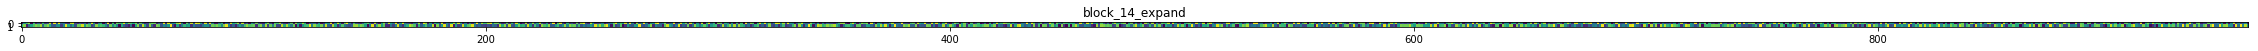

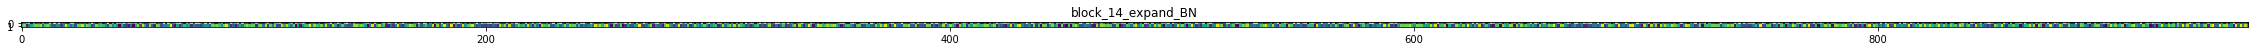

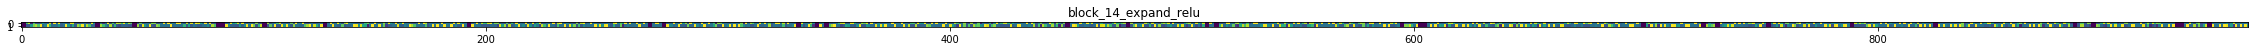

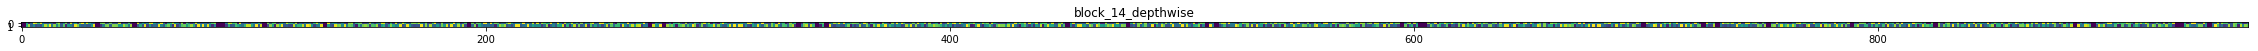

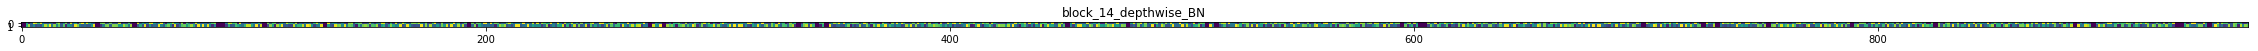

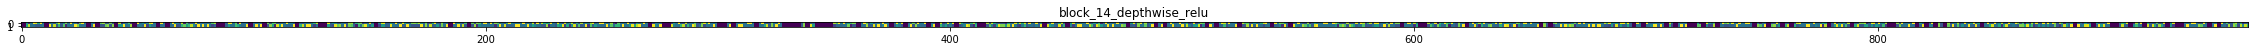

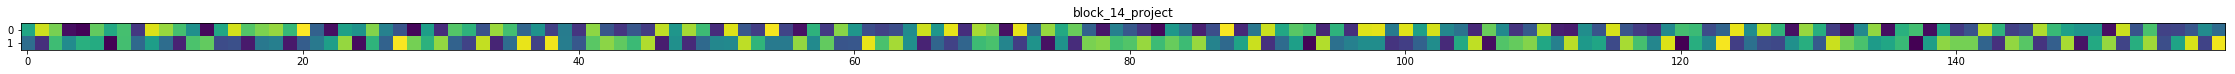

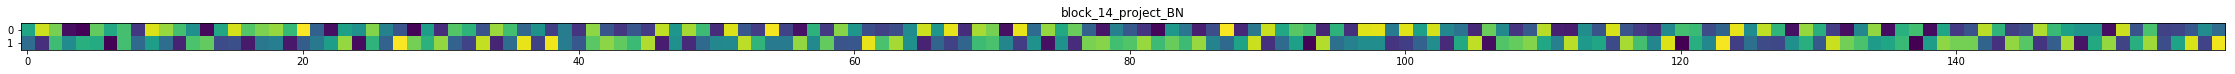

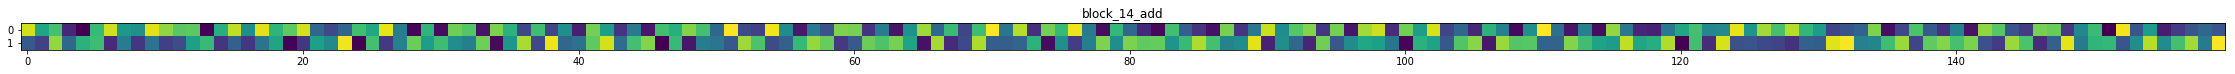

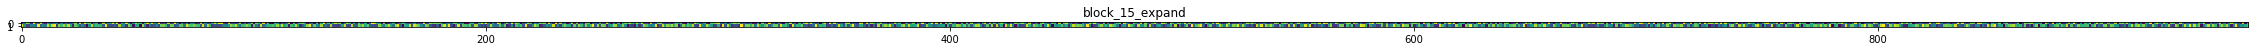

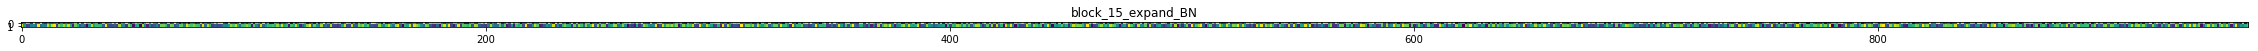

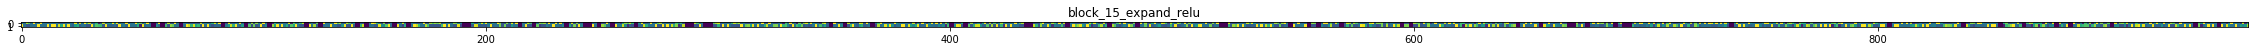

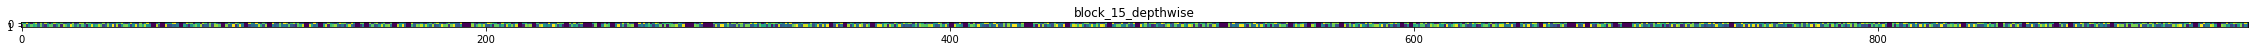

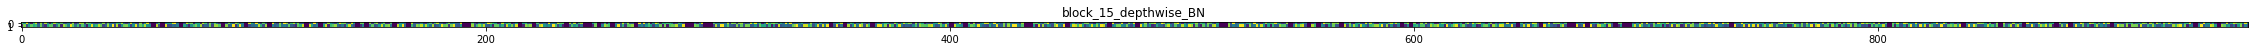

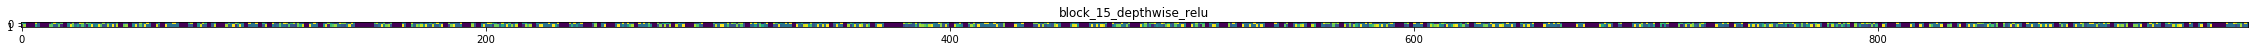

In [8]:
import numpy as np
import random
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt


# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(model.layers[0].input, successive_outputs)


img_path = random.choice(list((validation_dir / Path("AW")).iterdir()))
img = Image.open(img_path)
# img

x = np.array(img)
x = x.reshape((1,) + x.shape + (1,))
x = x / 255
# print(train_generator.class_indices)
print({index_class_dict[ind]: "{:3.1f}".format(pred) for ind, pred in enumerate(model.predict(x)[0])})

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names[1:], successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1] // 2  # number of features in feature map
        # The feature map has shape (1, height, width, n_features)
        height = feature_map.shape[1]
        width = feature_map.shape[2]
        # We will tile our images in this matrix
        display_grid = np.zeros((height, width * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * width: (i + 1) * width] = x
        # Display the grid
        scale = 40 / (n_features+1)
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        # plt.savefig("vis_{}.png".format(layer_name))
img.resize((128, 128))

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical"
)

Found 2341 images belonging to 9 classes.


In [37]:
evals = model.evaluate_generator(test_generator)

In [39]:
evals

[2.2181117311101137, 0.6851772770113743, 0.00854335753951303]

In [40]:
predictions = model.predict_generator(test_generator)

In [26]:
test_generator.class_indices

{'A': 0, 'AW': 1, 'D': 2, 'DW': 3, 'W': 4, 'no_key': 5}

In [41]:
x = []
y = []
k = 0
for e in test_generator:
    x.append(e[0])
    y.append(e[1])
    if k > 100:
        break
    k += 1
from itertools import chain

x = list(chain.from_iterable(x))
y = list(chain.from_iterable(y))

In [42]:
import numpy as np
predictions = model.predict(np.array(x))

In [43]:
maxs = np.argmax(predictions, axis=1)

In [44]:
max_y = np.argmax(y, axis=1)

In [45]:
max_y[:211]

array([7, 7, 2, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 5, 2, 7, 7, 7, 2,
       2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 3, 7,
       5, 7, 5, 2, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 2, 7, 3, 7, 3, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7,
       7, 7, 7, 2, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 3,
       7, 5, 7, 7, 7, 7, 7, 8, 2, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       2, 7, 2, 2, 2, 7, 7, 2, 2, 2, 7, 7, 5, 2, 2, 7, 2, 7, 2, 7, 2, 7,
       7, 7, 2, 7, 7, 7, 2, 8, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 7, 7, 7, 7,
       7, 5, 7, 7, 3, 7, 7, 8, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 2, 8, 7, 7,
       7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7], dtype=int64)

In [46]:
misclassified = []
for k in range(len(y)):
    if max_y[k] != maxs[k]:
        misclassified.append(k)

In [47]:
len(misclassified)

636

In [48]:
from PIL import Image
from random import choice

In [49]:
key_dict = {j: i for i, j in test_generator.class_indices.items()}

In [57]:
nr = choice(misclassified)
img = Image.fromarray((x[nr].reshape((x[nr].shape[0], x[nr].shape[1]))*255).astype("int8"), mode="L")
print("actual:", key_dict[max_y[nr]])
print("predicted:", key_dict[maxs[nr]], "with score = ", predictions[nr][maxs[nr]])
print("predicted score of actual:", predictions[nr][max_y[nr]])
img.show()

actual: W
predicted: D with score =  0.71044207
predicted score of actual: 0.28603935


Test image generator

In [1]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    fill_mode='nearest',
    channel_shift_range=2,
    rotation_range=2,
    shear_range=2,
    width_shift_range=2,
    height_shift_range=2
)

C:\Users\mivog\AppData\Local\Programs\Python\Python36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


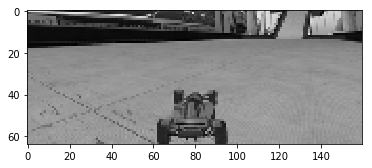

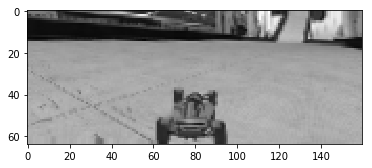

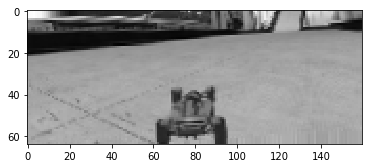

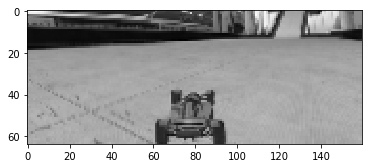

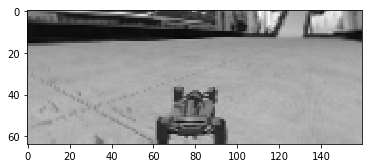

In [4]:
%matplotlib inline
# %matplotlib auto 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = r"E:\Trackmania Data\training_val_data\training_data\DW\ 1114.png"
img = load_img(img_path).convert("L").resize((160, 64))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
plt.figure(0)
imgplot = plt.imshow(img)
i = 1
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break